# Food App 
---

We build an algorithm to identify food items from an image with deep learning in Keras. In this notebook, we train a model using transfer learning (inception v3). 

## Step0: Create generator

The data is pre-processed in `0_dataset.ipynb`. All images are split into training, validation, and test sets, and within each directory, each image is put in the directory of its label. We use `ImageDataGenerator` and `flow_from_directory` to perform real-time data augmentations and train the model by batch. 

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


### data augmentation 

The following parameters are used for data augmentation in the training set. Each augmentation method is described in the Keras documentation, [ImageDataGenerator class](https://keras.io/preprocessing/image/)

In [2]:
train_datagen = ImageDataGenerator(
    rotation_range=90, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[.8, 1],
    channel_shift_range=30,
    fill_mode='reflect', 
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True
)

In [3]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [4]:
# set path to the data sets
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

# set input dimention to 299x299 (default for inception_v3)
dimentions = (299, 299)

batch_size = 32

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 60600 images belonging to 101 classes.


In [6]:
validation_generator = test_datagen.flow_from_directory(
    valid_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 15150 images belonging to 101 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(
    test_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 25250 images belonging to 101 classes.


## Step1: Build a model

### model using Inception v3

We use Inception v3 as a base model. It is pre-trained on ImageNet. Some layers are added: 

+ `AveragePooling2D`: it reduces variance in the data and computational complexity
+ `Dropout`: regularization for reducing overfitting

The activation is `softmax` which takes a un-normalized vector and normalizes it between 0 and 1 as a probability.

In [8]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import AveragePooling2D, Dropout, Dense, Flatten
from keras.models import Model

n_classes = 101

# base model is inception_v3 weights pre-trained on ImageNet
base_model = InceptionV3(
    weights='imagenet', 
    include_top=False,
    input_shape=(299,299,3)
)

x = base_model.output 

# added layers to the base model
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.4)(x)
x = Flatten()(x)

# add softmax activation
predictions = Dense(n_classes, activation='softmax')(x)    

model = Model(inputs=base_model.input, outputs=predictions)

### define learning rate

Learning rate is a hyperparameter that controls how much we adjust the weights with respect to the loss gradient. The loss over time tells if the value of the learning rate is good. For this project, we implement a step decay to reduce the learning rate by some factor every few epochs. 

References: Neural Networks Part 3: Learning and Evaluation, [Loss function](http://cs231n.github.io/neural-networks-3/#loss), [Annealing the learning rate](http://cs231n.github.io/neural-networks-3/#anneal)

In [9]:
def step_decay(epoch):
    initial_lr = 1e-2 
    
    if epoch < 9: 
        return initial_lr
    else: 
        return 0.00008 

In [10]:
import matplotlib.pyplot as plt                        
%matplotlib inline  

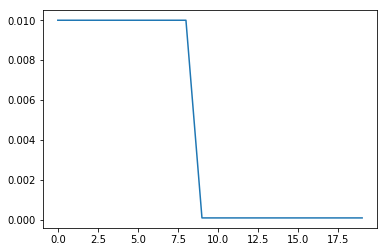

In [11]:
x = [i for i in range(20)]
y = [step_decay(i) for i in range(20)]
plt.plot(x, y)

### compile the model 

**optimizer**: we use a stochastic gradient descent(SGD) for the optimizer(it worked better than `Adam` optimizer `RMSProp` might be another option as well). As mentioned above, we anneal the learning rate over time. 

**model evaluation**: To evaluate the model, we use accuracy (top-one) and top-five accuracy. Accuracy (top1) is the conventional accuracy where the predicted label needs to be matched with the correct label. Top5 accuracy means that the any of the top-five predicted labels need to match with the correct label. 

In [12]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.metrics import top_k_categorical_accuracy
import math

# optimizer 
opt = SGD(lr=.01, momentum=.9)

# add LearningRateScheduler to update it
lr_scheduler = LearningRateScheduler(step_decay)

# calculate top_5_accuracy to evalute the model 
def top_5_accuracy(y_true, y_pred): 
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# putting them together and compile the model 
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy', 
    metrics=['accuracy', top_5_accuracy]
)

## Step2: Train the model

The model is trained for 16 epochs on Google Compute Engine with 1 GPU NVIDIA Tesla K80. It took about 10.5 hours to complete the training. 

In [13]:
from keras.callbacks import ModelCheckpoint  

model_file = 'saved_models/weights.best.InceptionV3_final_model.hdf5'
checkpointer = ModelCheckpoint(filepath=model_file, 
                               verbose=1, save_best_only=True)

In [14]:
%%time

epochs = 16

history = model.fit_generator(train_generator, 
                                 validation_data=validation_generator, 
                                 epochs=epochs, 
                                 callbacks=[checkpointer, lr_scheduler],
                                 steps_per_epoch=train_generator.samples // batch_size, 
                                 validation_steps=validation_generator.samples // batch_size
                                )

Epoch 1/16
1893/1893 [==============================] - 2207s 1s/step - loss: 2.4887 - acc: 0.3993 - top_5_accuracy: 0.6596 - val_loss: 4.0182 - val_acc: 0.1927 - val_top_5_accuracy: 0.4052

Epoch 00001: val_loss improved from inf to 4.01819, saving model to saved_models/weights.best.InceptionV3_final_model.hdf5
Epoch 2/16
1893/1893 [==============================] - 2194s 1s/step - loss: 1.7062 - acc: 0.5652 - top_5_accuracy: 0.8178 - val_loss: 2.5410 - val_acc: 0.4073 - val_top_5_accuracy: 0.6733

Epoch 00002: val_loss improved from 4.01819 to 2.54097, saving model to saved_models/weights.best.InceptionV3_final_model.hdf5
Epoch 3/16
1893/1893 [==============================] - 2189s 1s/step - loss: 1.4488 - acc: 0.6260 - top_5_accuracy: 0.8576 - val_loss: 2.0935 - val_acc: 0.4961 - val_top_5_accuracy: 0.7633

Epoch 00003: val_loss improved from 2.54097 to 2.09346, saving model to saved_models/weights.best.InceptionV3_final_model.hdf5
Epoch 4/16
1893/1893 [============================

### Plot the training accuracy over epochs

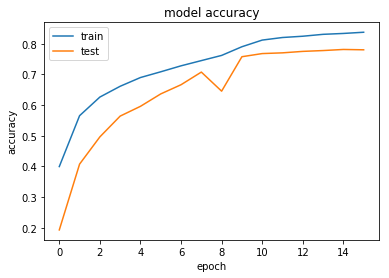

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.show()

### Plot the training loss over epochs

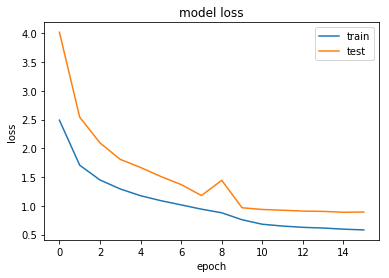

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.show()

## Step3: Model evaluation

We load the best model found while training. Then, we evaluate it on the training set using `evaluate_generator`(no data augmentation). 


After training 16 epochs, the model achieved 0.5419 for training loss, 87.5% for accuracy, 96.875% for top-five accuracy.  

In [17]:
model.load_weights(model_file)
model.evaluate_generator(test_generator, steps=10, verbose=1)

10/10 [==============================] - 12s 1s/step


[0.5419135585427284, 0.875, 0.96875]

### Save the model

In [18]:
### saving the trained model
# serialize model to JSON
model_json = model.to_json()
with open("saved_models/food101_final_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("saved_models/food101_final_model.h5")

## Step4: Test the model

We test the model using the some images found online. The outputs look better than what I expected. 

In [19]:
## Load the class labels (which are indexes are the same as the ones from generator)
with open('data/labels.txt', 'r') as f: 
    food101 = [l.strip().lower() for l in f]

In [20]:
from keras.preprocessing import image
import numpy as np 

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(299, 299))
    # convert PIL.Image.Image type to 3D tensor with shape (299, 299, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 299, 299, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [21]:
import cv2  

def img_analysis(img_path, plot=False): 
    # process image 
    img = path_to_tensor(img_path)
    img = preprocess_input(img)
    
    # make prediction 
    predicted_vec = model.predict(img)
    predicted_label = food101[np.argmax(predicted_vec)]
    
    # show predicted image 
    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.axis('off')
    plt.title("yummy! It looks like {}".format(predicted_label))
    plt.show()    
    
    # show top 5 predictions with probability
    if plot:
        # take top 5 probable pics 
        top5_probs = np.sort(predicted_vec)[0][-5:]
        top5_labels = np.argsort(predicted_vec)[0][-5:]
        
        # plot bar graph 
        x_pos = np.arange(len(top5_labels))
        plt.bar(x_pos, top5_probs)
        plt.title("top 5 predictions")
        plt.xticks(x_pos, [food101[int(idx)] for idx in top5_labels], rotation=20)
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.show()


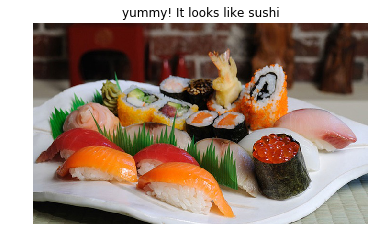

In [22]:
img_analysis('test_imgs/sushi.jpg')

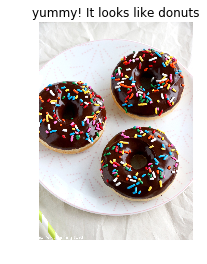

In [23]:
img_analysis('test_imgs/donuts.jpg')

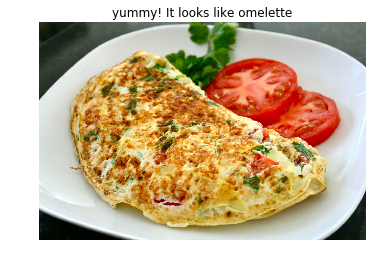

In [24]:
img_analysis('test_imgs/omlet.jpg')

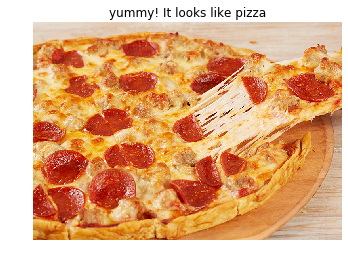

In [25]:
img_analysis('test_imgs/pizza.jpg')

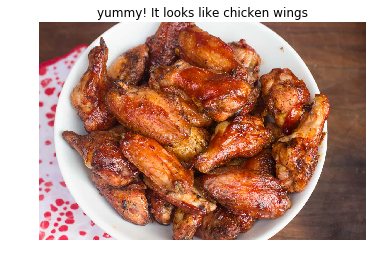

In [26]:
img_analysis('test_imgs/chicken_wings.jpg')

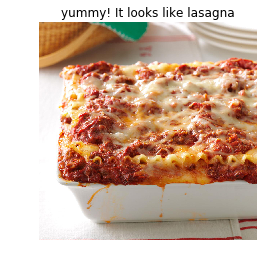

In [27]:
img_analysis('test_imgs/lasagna.jpg')

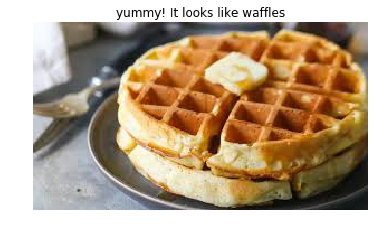

In [28]:
img_analysis('test_imgs/waffles.jpg')

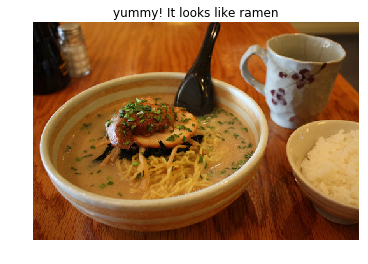

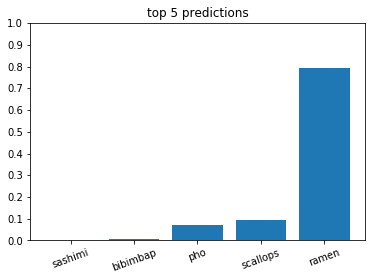

In [29]:
img_analysis('test_imgs/ramen.jpg', plot=True)

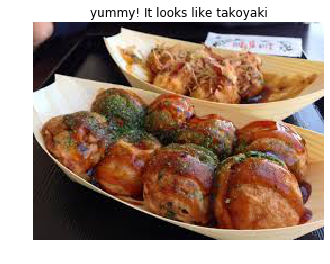

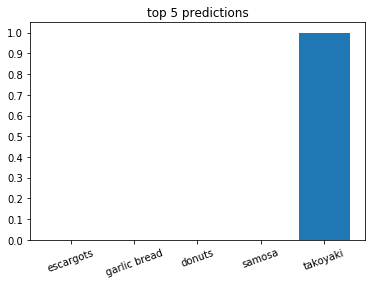

In [30]:
img_analysis('test_imgs/takoyaki.jpg', plot=True)